In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd 
import shapely 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import textwrap
!pip install country_converter 
import country_converter as coco


/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 KB 217.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for country_converter: filename=country_converter-0.7.4-py3-none-any.whl size=53543 sha256=5e1ff4b3a40952ee61a22f66245ae40e5a8808587f3b8aedfaa30f59bea3cc6f
  Stored in directory: /root/.cache/pip/wheels/69/cf/84/9ebca78737327440a0bb5faa6d0380e9017730534cf0dbcb8c
Successfully built country_converter


# **Getting the data by Pandas**

In [2]:
df1=pd.read_csv('../chinese debt trap all over the world. - projects.csv')
df2=pd.read_csv('../chinese debt trap in Africa (sector wise).csv')

# **Checking the datas are imported/not**

In [3]:
df1.head()

,Expand All | Collapse All,YEAR,AMOUNT,LENDER,BORROWER,SECTOR,SENSITIVE TERRITORY OVERLAP,Country
0,"“Lar Patriota"" Infrastructure (Phase 1)",2011,$50M,CDB,Government,Transport,None Known,Angola
1,"10-Year Oil Supply Plan (10Mt/Year), ""Oil for ...",2009,$7.0B,CDB,Petrobras,"Extraction, pipelines",None Known,Brazil
2,1000 housing project,2012,$47M,ExImBank,Government,Government,None Known,Suriname
3,115kV Transmission Line and Substation from Ph...,2009,$475M,ExImBank,Electricite Du Cambodge,Power,None Known,Cambodia
4,151 Multisector infrastructure projects,2016,$600M,CDB,Central Bank of Kenya,Mulit-sector/discretionary,None Known,Kenya


In [4]:
df1.rename(columns={'Expand All | Collapse All':'Project'},inplace=True)

In [5]:
df2.head()

,S.no,Project,Year,Lender,$ Allocation,Country,Invested On
0,1,"Luanda Railway Phase I Rehabilitation, 444km (...",2002,CHEXIM,$90M,Angola,Transportation
1,2,"Kipsigak-Serem-Shamakhokho Road, 54km, Loan 2",2001,CIDCA,$6M,Kenya,Transportation
2,3,"Addis-Adama Expressway Phase I, 80km",2009,CHEXIM,$349M,Ethiopia,Transportation
3,4,"Railway Modernisation Project 1 (Idu-Kaduna), ...",2010,CHEXIM,$500M,Nigeria,Transportation
4,5,Special Train Loan - TAZARA,2001,CIDCA,$6M,Zambia,Transportation


# Getting some insight about data types/null values in both the dataframes

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Project                      858 non-null    object
 1   YEAR                         858 non-null    int64 
 2   AMOUNT                       858 non-null    object
 3   LENDER                       858 non-null    object
 4   BORROWER                     857 non-null    object
 5   SECTOR                       858 non-null    object
 6   SENSITIVE TERRITORY OVERLAP  858 non-null    object
 7   Country                      858 non-null    object
dtypes: int64(1), object(7)
memory usage: 53.8+ KB


**There is a null value in borrower. Lets check that**

In [7]:
df1[df1['BORROWER'].isnull()]

,Project,YEAR,AMOUNT,LENDER,BORROWER,SECTOR,SENSITIVE TERRITORY OVERLAP,Country
802,Unspecified,2009,$500M,ExImBank,NaN,Mulit-sector/discretionary,None Known,Venezuela


# **As we can see the project name is even not specified we can drop it**

In [8]:
df1.dropna(inplace=True)

In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   S.no          1188 non-null   int64 
 1   Project       1188 non-null   object
 2   Year          1188 non-null   int64 
 3   Lender        1188 non-null   object
 4   $ Allocation  1188 non-null   object
 5   Country       1188 non-null   object
 6   Invested On   1188 non-null   object
dtypes: int64(2), object(5)
memory usage: 65.1+ KB


# Lets check the sectrors

In [10]:
df1['SECTOR'].unique()   #there is fTransport in place of transport. let's change it

array(['Transport', 'Extraction, pipelines', 'Government', 'Power',
       'Mulit-sector/discretionary', 'Telecom', 'Other construction',
       'Agriculture, food', 'Manufacturing', 'fTransport'], dtype=object)

In [11]:
df1['SECTOR']=df1['SECTOR'].apply(lambda x:'Transport' if x=='fTransport' else x)

# **Let's convert the budgets into numericals**

In [12]:
def amount(a):
    y=a
    if ',' in a:
        a=a.replace(',','')
    a=float(a[1:-1])
    if y[-1]=='M':
        return a*10e6
    elif y[-1]=='B':
        return a*10e9
    else:
        return 'Please check'

In [13]:
df1['AMOUNT']=df1['AMOUNT'].apply(amount)
df2['$ Allocation']=df2['$ Allocation'].apply(amount)

#  **Let's change the year data into timestamp datatype**

In [14]:
df1['YEAR']=pd.to_datetime(df1['YEAR'].map(str)).dt.year
df2['Year']=pd.to_datetime(df2['Year'].map(str)).dt.year

# Lets create a contry code column which may help us in creating plot in world map.

In [15]:
def coco_conv(x):
    try:
        x=coco.convert(x)
    except:
        x=None
    return x

In [16]:
df1['Country code']=df1['Country'].apply(coco_conv)

In [17]:
df2['Country code']=df2['Country'].apply(coco_conv)

In [18]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [19]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [20]:
world.columns=['pop_est', 'continent', 'name', 'Country code', 'gdp_md_est', 'geometry']

In [21]:
df1=pd.merge(df1,world,on='Country code',how='inner')
df2=pd.merge(df2,world,on='Country code',how='inner')

In [22]:
df1.head()    

,Project,YEAR,AMOUNT,LENDER,BORROWER,SECTOR,SENSITIVE TERRITORY OVERLAP,Country,Country code,pop_est,continent,name,gdp_md_est,geometry
0,"“Lar Patriota"" Infrastructure (Phase 1)",2011,500000000.0,CDB,Government,Transport,None Known,Angola,AGO,29310273,Africa,Angola,189000.0,"MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4..."
1,3 Training Centers and Equipment for Angolan R...,2016,390000000.0,ExImBank,Government,Transport,None Known,Angola,AGO,29310273,Africa,Angola,189000.0,"MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4..."
2,Angola's Railways Workshops Rehabilitation and...,2011,830000000.0,ExImBank,Government,Manufacturing,None Known,Angola,AGO,29310273,Africa,Angola,189000.0,"MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4..."
3,"Benguela, EN100 Road Rehabilitation, Cabo Ledo...",2016,410000000.0,CDB,Government,Transport,Within Critical Habitats,Angola,AGO,29310273,Africa,Angola,189000.0,"MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4..."
4,Cabina University Campus Construction Contract...,2016,500000000.0,CDB,Government,Government,None Known,Angola,AGO,29310273,Africa,Angola,189000.0,"MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4..."


In [23]:
df2.head()

,S.no,Project,Year,Lender,$ Allocation,Country,Invested On,Country code,pop_est,continent,name,gdp_md_est,geometry
0,1,"Luanda Railway Phase I Rehabilitation, 444km (...",2002,CHEXIM,9.000000e+08,Angola,Transportation,AGO,29310273,Africa,Angola,189000.0,"MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4..."
1,42,"Luanda Electrical Network Expansion, Phase I",2002,CHEXIM,1.500000e+08,Angola,Power,AGO,29310273,Africa,Angola,189000.0,"MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4..."
2,76,Sonangol Development,2011,CDB,2.000000e+10,Angola,Mining,AGO,29310273,Africa,Angola,189000.0,"MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4..."
3,86,TPA Production Center in Camama Construction a...,2005,CHEXIM,6.000000e+08,Angola,ICT,AGO,29310273,Africa,Angola,189000.0,"MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4..."
4,122,Luanda's Water Supply System,2005,CHEXIM,4.000000e+08,Angola,Water,AGO,29310273,Africa,Angola,189000.0,"MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4..."


# Converting pandas to geopandas for easier plotting

In [24]:
df1_geo = gpd.GeoDataFrame(df1)
df2_geo=gpd.GeoDataFrame(df2)

# Lets plot The countries on the world map

**The contries which are still safe from thr debt trap are green and the others are in red with a amount of debt propotional to depth of red color**

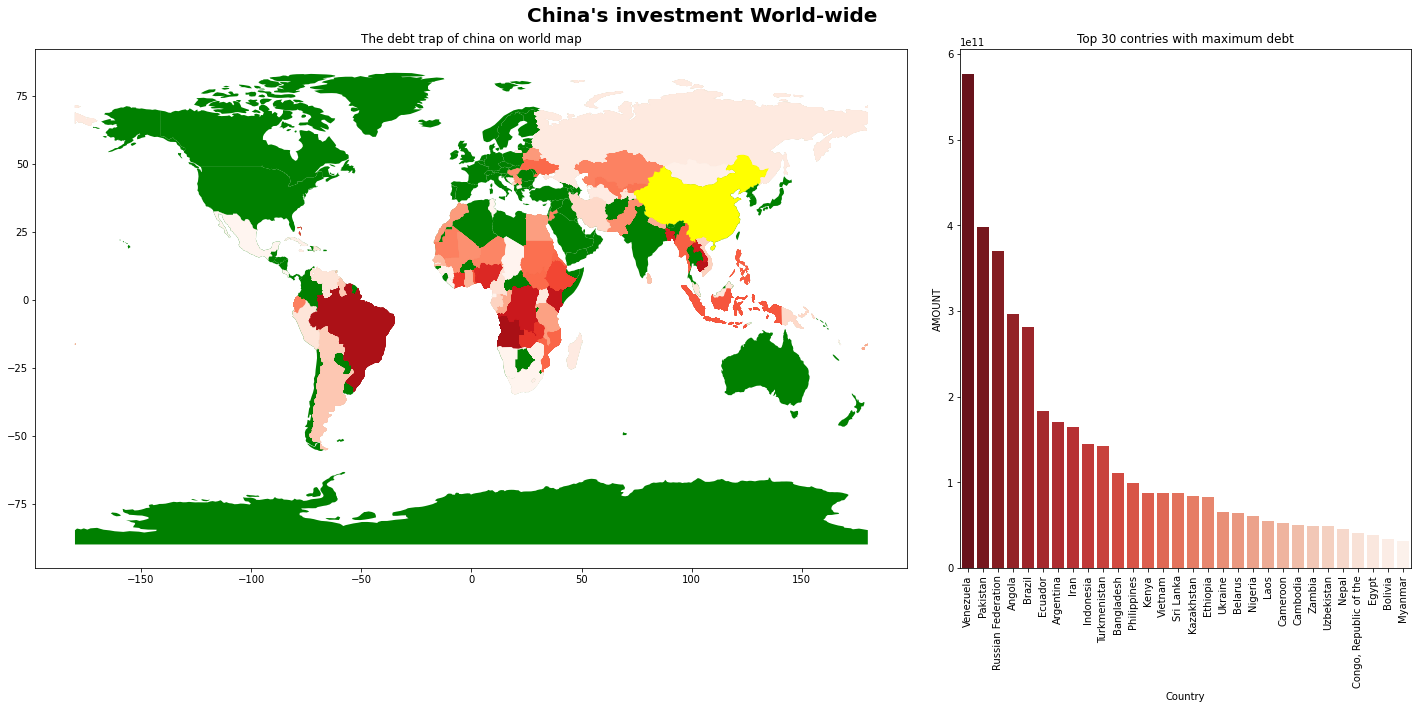

In [25]:
fig,(ax1,ax2)=plt.subplots(1,2,gridspec_kw={'width_ratios': [2, 1]},figsize=(20,10))
plt.suptitle("China's investment World-wide",size=20,weight='bold')
plt.subplot(1,2,1)
plt.title('The debt trap of china on world map')
world.plot(color='green',ax=ax1)
df1_geo.plot(ax=ax1,legend=True,cmap='Reds_r',cax='AMOUNT') 
world[world['Country code'] == 'CHN'].plot(color='yellow',ax=ax1)
data=df1.groupby('Country').sum().reset_index().sort_values('AMOUNT',ascending=False)[['Country','AMOUNT']]
plt.subplot(1,2,2)
plt.title('Top 30 contries with maximum debt')
plt.xticks(rotation=90)
sns.barplot(data=data.head(30),x='Country',y='AMOUNT',ax=ax2,palette='Reds_r')
plt.tight_layout()

<h1>I have attached this map from internet to show the strategic paths in world trade to compare with the above ploted map to understand the china's debt trap plan <h1>
<img src="https://i0.wp.com/transportgeography.org/wp-content/uploads/Map-Trade-Routes-1400-1800.png?resize=900%2C450&amp;ssl=1" jsaction="load:XAeZkd;" jsname="HiaYvf" class="n3VNCb KAlRDb" alt="Major Global Trade Routes, 1400-1800 | The Geography of Transport Systems" data-noaft="1" style="width: 450px; height: 325px; margin: 0px;">

**The contries in Asia which are still safe from thr debt trap are green and the others are in red with a amount of debt propotional to depth of red color**

<AxesSubplot:title={'center':'Sector-wise investment of china'}, xlabel='SECTOR'>

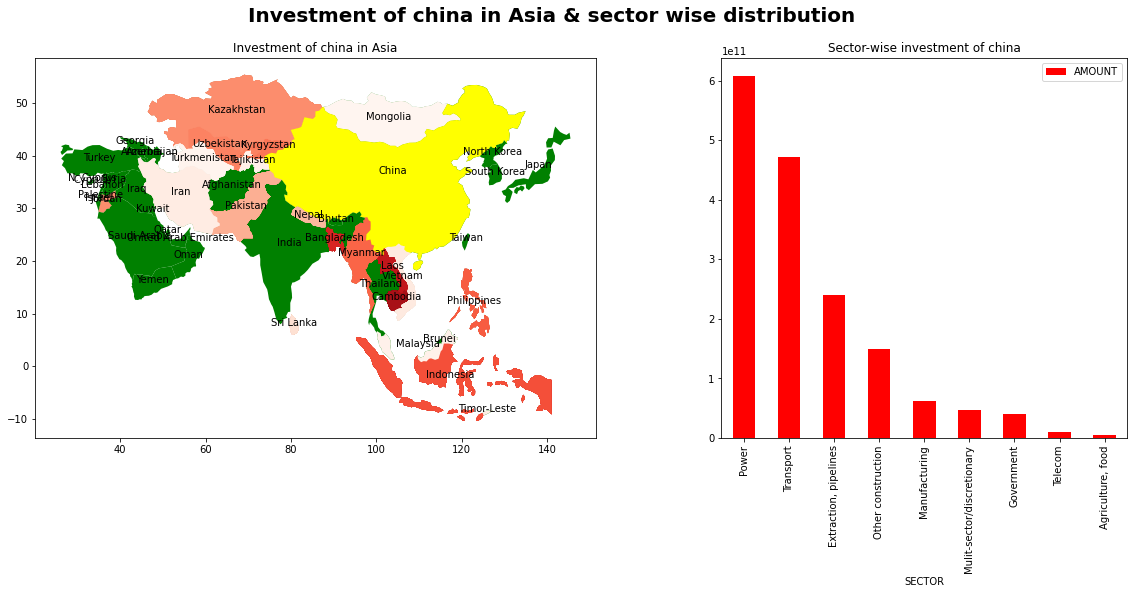

In [26]:
fig,(ax1,ax2)=plt.subplots(1,2,gridspec_kw={'width_ratios': [3,2]},figsize=(20,7))
plt.suptitle('Investment of china in Asia & sector wise distribution',size=20,weight='bold')
plt.subplot(1,2,1)
plt.title('Investment of china in Asia')
world[world.continent == 'Asia'].plot(figsize=(15,15),color='green',ax=ax1)
df1_geo[df1_geo['continent']=='Asia'].plot(ax=ax1,legend=True,cmap='Reds_r',cax='AMOUNT') 
world[world['Country code'] == 'CHN'].plot(ax=ax1,figsize=(15,15),color='yellow')
world[world.continent == 'Asia'].apply(lambda x: ax1.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

plt.subplot(1,2,2)
plt.title('Sector-wise investment of china')
df1_geo[df1_geo.continent=='Asia'].groupby('SECTOR',as_index=False).sum().sort_values('AMOUNT',ascending=False).plot.bar(x='SECTOR',y='AMOUNT',ax=ax2,color='red')

<AxesSubplot:title={'center':'Sector-wise investment of china'}, xlabel='Invested On'>

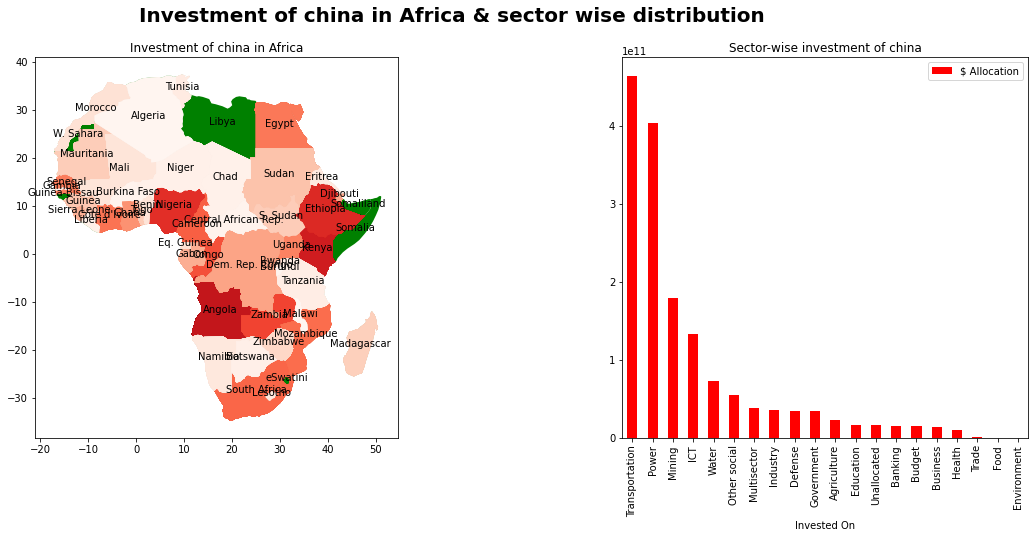

In [27]:
fig,(ax1,ax2)=plt.subplots(1,2,gridspec_kw={'width_ratios': [3,2]},figsize=(20,7))
plt.suptitle('Investment of china in Africa & sector wise distribution',size=20,weight='bold')
plt.subplot(1,2,1)
plt.title('Investment of china in Africa')
world[world.continent == 'Africa'].plot(figsize=(15,15),color='green',ax=ax1)
df2_geo.plot(ax=ax1,legend=True,cmap='Reds_r',cax='$ Allocation') 
world[world.continent == 'Africa'].apply(lambda x: ax1.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

plt.subplot(1,2,2)
plt.title('Sector-wise investment of china')
df2_geo.groupby('Invested On',as_index=False).sum().sort_values('$ Allocation',ascending=False).plot.bar(x='Invested On',y='$ Allocation',ax=ax2,color='red')

**The contries in africa which are still safe from thr debt trap are green and the others are in red with a amount of debt propotional to depth of red color**

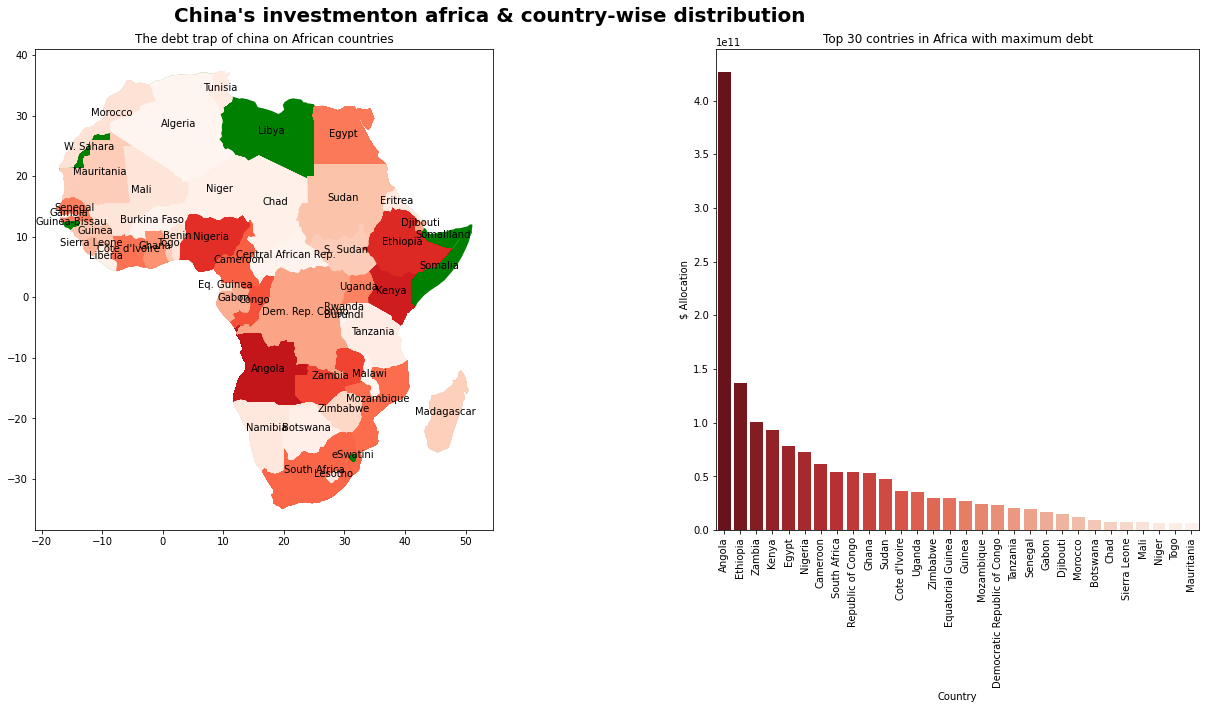

In [28]:
fig,(ax1,ax2)=plt.subplots(1,2,gridspec_kw={'width_ratios': [2,1]},figsize=(20,10))
plt.suptitle("China's investmenton africa & country-wise distribution",size=20,weight='bold')
plt.subplot(1,2,1)
plt.title('The debt trap of china on African countries')
world[world['continent']=='Africa'].plot(color='green',ax=ax1)
df2_geo.plot(ax=ax1,legend=True,cmap='Reds_r',cax='AMOUNT') 
world[world.continent == 'Africa'].apply(lambda x: ax1.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

data=df2_geo.groupby('Country').sum().reset_index().sort_values('$ Allocation',ascending=False)[['Country','$ Allocation']]
plt.subplot(1,2,2)
plt.title('Top 30 contries in Africa with maximum debt')
plt.xticks(rotation=90)
sns.barplot(data=data.head(30),x='Country',y='$ Allocation',ax=ax2,palette='Reds_r')
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Invested On', ylabel='$ Allocation'>

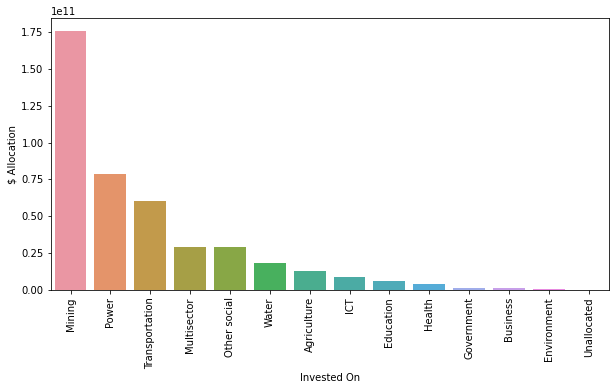

In [29]:
data=df2_geo[df2_geo.Country=='Angola'].groupby('Invested On',as_index=False).sum().sort_values('$ Allocation',ascending=False)
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
sns.barplot(data=data,y='$ Allocation',x='Invested On')

# Year wise spending of china internationally

,YEAR,AMOUNT,pop_est,gdp_md_est
0,2008,7.422000e+10,2533899057,18148107.0
1,2009,6.204000e+11,4058875897,39052174.0
2,2010,4.102200e+11,2075786359,14648964.0
3,2011,3.377900e+11,3637416050,20432242.0
4,2012,3.473100e+11,2842120635,16932753.0
5,2013,4.181100e+11,5345707353,40381554.0
6,2014,4.820600e+11,4785291570,39339646.0
7,2015,5.031500e+11,5020569850,39754747.0
8,2016,7.467300e+11,5899659223,45838899.0
9,2017,4.870900e+11,4594532525,37262014.0


<AxesSubplot:xlabel='YEAR', ylabel='AMOUNT'>

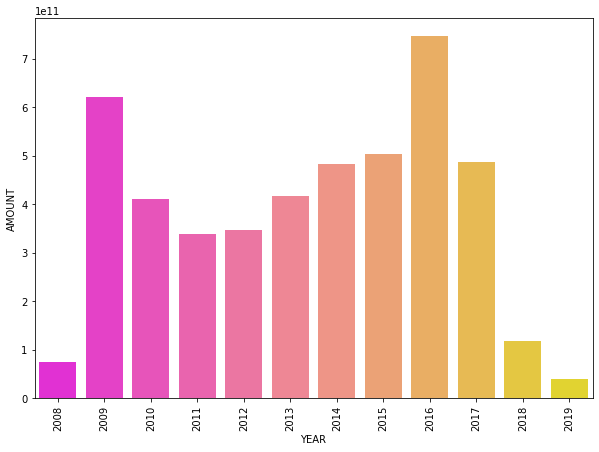

In [30]:
plt.figure(figsize=(10,7))
plt.xticks(rotation=90)
data=df1.groupby('YEAR').sum().reset_index().sort_values('YEAR').sort_values('YEAR')
display(data)
sns.barplot(data=data,x='YEAR',y='AMOUNT',palette='spring')

# Let's check how china invested money in different continent & different sector

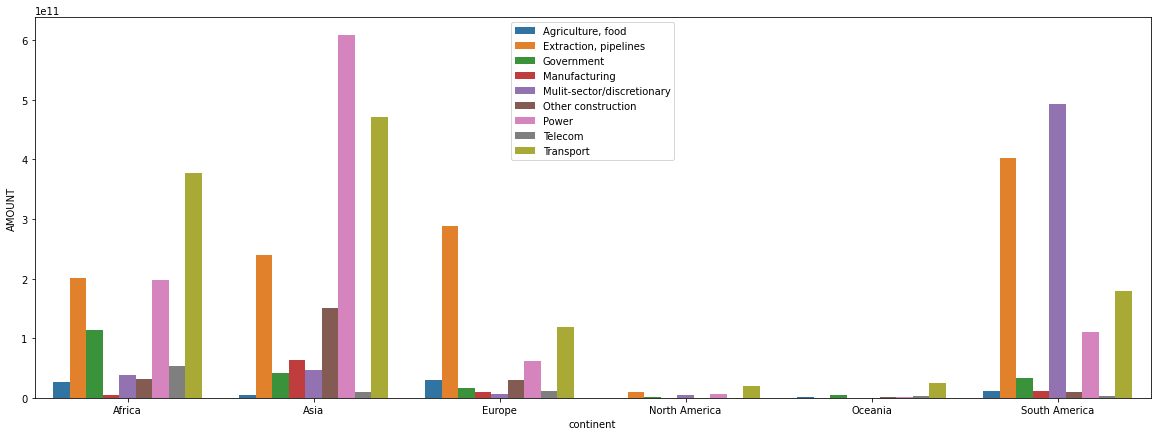

In [31]:
data=df1_geo.groupby(['continent','SECTOR'],as_index=False).sum()
plt.figure(figsize=(20,7))
ax=sns.barplot(data=data,x='continent',y='AMOUNT',hue='SECTOR')
ax.legend(loc='upper center')

**We can see china is focousing on power in ASIA region for it's power requirement like electricity,transport in AFRICA for mineral rich region and trade paths and pipelines in europe including russia for gas supply.**

# Lets check top 25 countries on which china invested the most(world wide)

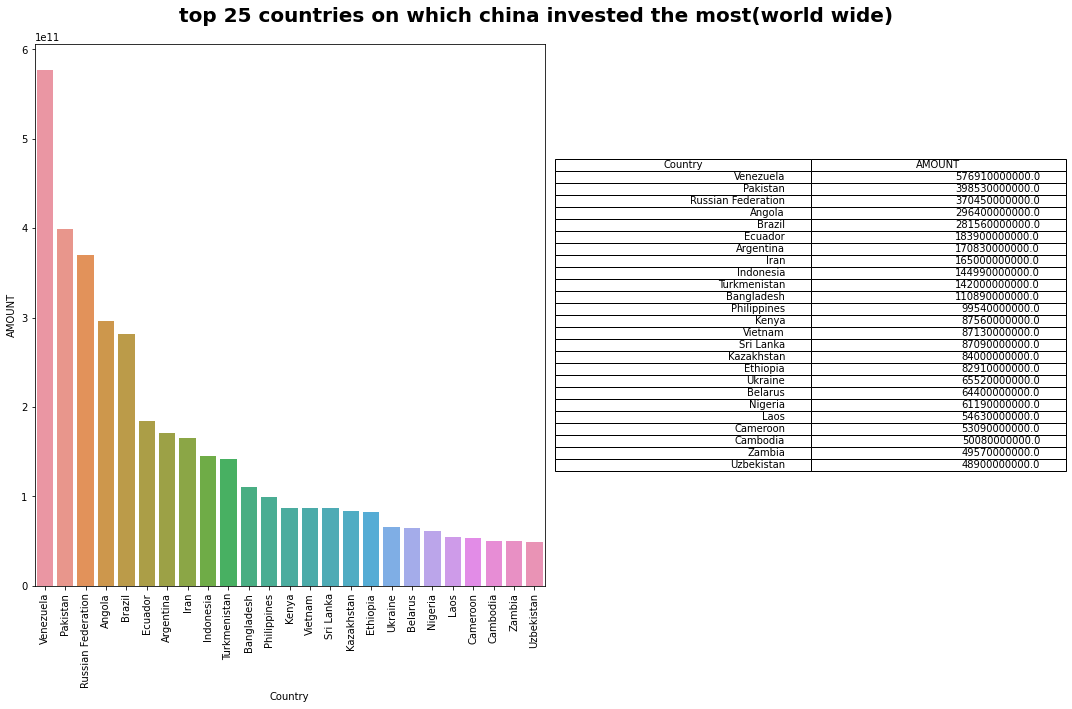

In [32]:
plt.figure(figsize=(15,10))
plt.suptitle('top 25 countries on which china invested the most(world wide)',size=20,weight='bold')
data=df1.groupby('Country').sum().reset_index().sort_values('AMOUNT',ascending=False)[['Country','AMOUNT']]
plt.subplot(1,2,1)
plt.xticks(rotation=90)
sns.barplot(data=data.head(25),x='Country',y='AMOUNT')
plt.subplot(1,2,2)
plt.axis('off')
plt.tight_layout()
plt.table(cellText=data.head(25).values, colLabels=data.columns, loc='center')

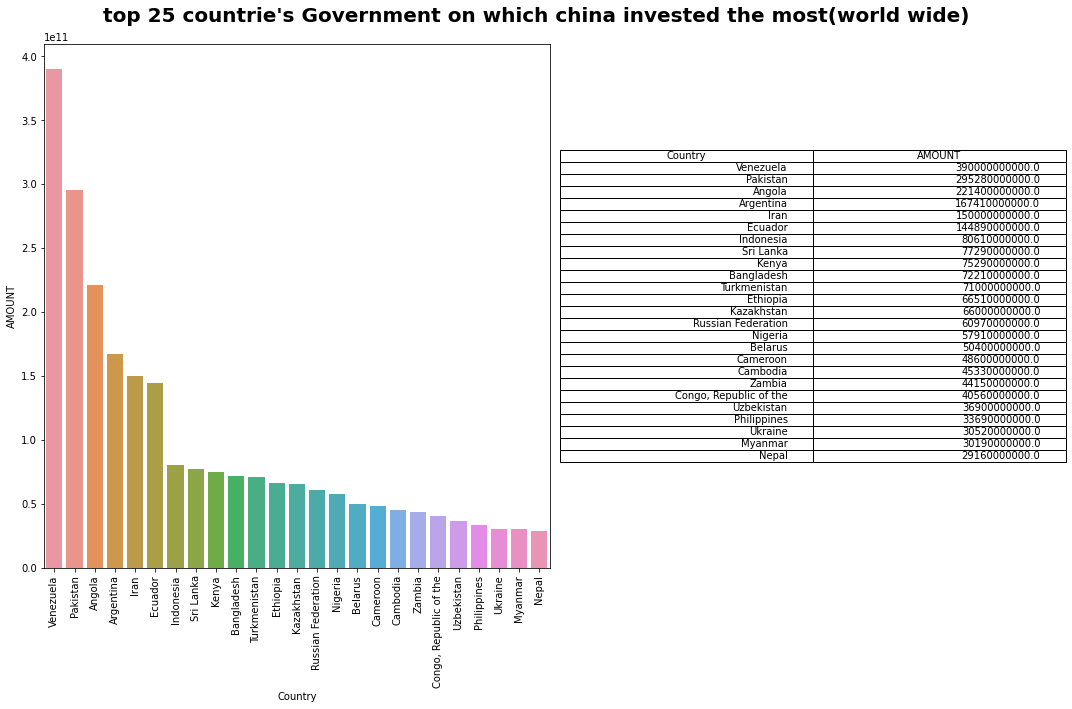

In [33]:
plt.figure(figsize=(15,10))
plt.suptitle("top 25 countrie's Government on which china invested the most(world wide)",size=20,weight='bold')
data=df1[df1['BORROWER']=='Government'].groupby('Country').sum().reset_index().sort_values('AMOUNT',ascending=False)[['Country','AMOUNT']]
plt.subplot(1,2,1)
plt.xticks(rotation=90)
sns.barplot(data=data.head(25),x='Country',y='AMOUNT')
plt.subplot(1,2,2)
plt.axis('off')
plt.tight_layout()
plt.table(cellText=data.head(25).values, colLabels=data.columns, loc='center')

# We can analyse indivisual contries as follows
**You can put any country's name from the data**

,Project,YEAR,AMOUNT
0,Hambantota Natural Gas-Powered Electrical Station,2018,1.000000e+10
1,"Central Expressway Project - Phase I, Stage I",2018,9.890000e+09
2,Norochcholai (Lakvijaya) Power Plant Phase 2,2009,8.910000e+09
3,Hambantota Deep Sea Port Phase II (PPP),2012,8.090000e+09
4,Hambantota Port Development Project -Phase II ...,2012,6.000000e+09
5,Rehabilitation and Improvement of Priority Roa...,2011,5.000000e+09
6,Construction of Outer Circular Highway Project...,2014,4.940000e+09
7,Southern Expressway Extension- Section 4 from ...,2014,4.120000e+09
8,Northern Road Rehabilitation Project,2010,3.020000e+09
9,Rehabilitation and Improvement of Priority Roa...,2014,3.000000e+09


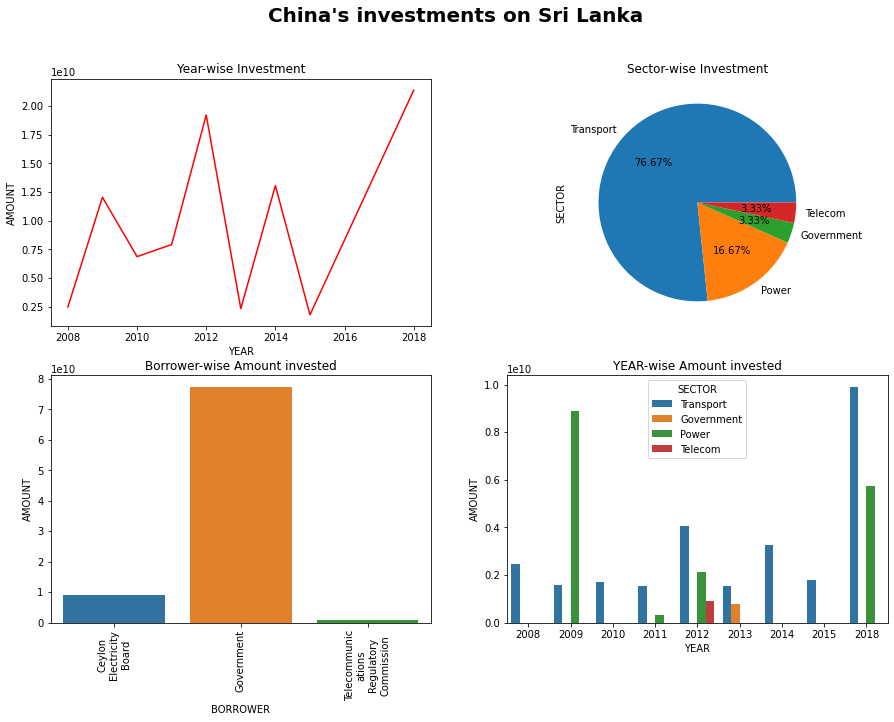

In [34]:
country='Sri Lanka'
data=df1[df1['Country']==country]
ax=plt.figure(figsize=(15,10))
plt.suptitle(f"China's investments on {country}",weight='bold',size=20)
plt.subplot(2,2,1)
plt.title('Year-wise Investment')
sns.lineplot(data=data.groupby('YEAR').sum().reset_index(),x='YEAR',y='AMOUNT',color='r')
plt.subplot(2,2,2)
plt.title('Sector-wise Investment')
data['SECTOR'].value_counts().plot.pie(autopct='%.2f%%')
plt.subplot(2,2,3)
plt.title('Borrower-wise Amount invested')
plt.xticks(rotation=90)
ax=sns.barplot(data=data.groupby('BORROWER').sum().reset_index(),x='BORROWER',y='AMOUNT')
labels = [textwrap.fill(label.get_text(), 12) for label in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.subplot(2,2,4)
plt.title('YEAR-wise Amount invested')
ax=sns.barplot(data=data,x='YEAR',y='AMOUNT',hue='SECTOR',ci=False)
labels = [textwrap.fill(label.get_text(), 12) for label in ax.get_xticklabels()]
display(data.sort_values('AMOUNT',ascending=False)[['Project','YEAR','AMOUNT']].reset_index(drop=True))

**We can clearly see from the above graphs Sri Lanka government took heavy loans during 2018 to develope Transport & power which led to it's government collapse**